# Feature figures and stats

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# parameters
phenotype = 'group'
model_suffix = '_site_confounds_removed'
denoise = 'simple+gsr'
n_batch = 200
n_batch_null = 1000
weight_type = 'prediction'
n_targets = 10

# load results
df_list = []
for model in ['multilayer_metamatch', 'logreg']:
    in_file = (f"../results/feature_analysis/pathway_phenotype-{phenotype}_"
            f"model-{model}{model_suffix}_denoise-{denoise}_"
            f"n_batch-{n_batch}_n_batch_null-{n_batch_null}_"
            f"weight_type-{weight_type}_n_targets-{n_targets}.csv")
    df = pd.read_csv(in_file)
    df['model_label'] = model
    df_list.append(df)
df_all = pd.concat(df_list)
df_all.head()

,roi,value,model,iteration,model_label
0,NAc-shell,-0.000449,model,0.0,multilayer_metamatch
1,NAc-shell,-0.000259,model,1.0,multilayer_metamatch
2,NAc-shell,0.000100,model,2.0,multilayer_metamatch
3,NAc-shell,0.001284,model,3.0,multilayer_metamatch
4,NAc-shell,-0.001430,model,4.0,multilayer_metamatch


## Perform stats

In [2]:
# percentile based statistical analysis
results = pd.DataFrame()
r_factor = 1000
for model_label in ['multilayer_metamatch', 'logreg']:
    print(model_label)
    df = df_all.loc[df_all.model_label == model_label]
    for roi in df.roi.unique():
        data = df.loc[(df.roi == roi) & (df.model == 'model'), 'value']
        median = np.round(data.median()* r_factor, 2) 

        quantile_low = np.round(data.quantile(0.25)* r_factor, 2)
        quantile_high = np.round(data.quantile(0.75)* r_factor, 2) 

        value = data.median()
        _results = pd.DataFrame()
        _results['Model'] = [model_label.capitalize()]
        _results['Pathway'] = roi
        _results['PFW'] = f"{median} ({quantile_low} - {quantile_high})"

        # calculate perms
        for null_model in ['permutation', 'SC-Cort', 'Cort-Cort']:
            null_distribution = df.loc[(df.roi == roi) &
                                    (df.model == null_model), 'value'].values
            
            percentile = (null_distribution < value).mean()
            
            p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
            _results[null_model] = percentile.copy()
        results = pd.concat([results, _results])

# Reformat for table
results.replace('NAc-shell','NAcc', inplace=True)
results.replace('PUT-VA','vPut', inplace=True)
results.replace('CAU-DA','dCaud', inplace=True)
results.replace('PUT-DP','dPut', inplace=True)
results.to_csv('../results/SC_pathways.csv',index=False)
results.head(10)

multilayer_metamatch
logreg


,Model,Pathway,PFW,permutation,SC-Cort,Cort-Cort
0,Multilayer_metamatch,NAcc,0.2 (-0.37 - 0.74),0.9226,0.4836,0.7386
0,Multilayer_metamatch,dCaud,-2.77 (-3.55 - -1.96),0.0124,0.0216,0.1640
0,Multilayer_metamatch,dPut,-2.33 (-2.93 - -1.71),0.0076,0.0390,0.2326
0,Multilayer_metamatch,vPut,-1.96 (-2.57 - -1.41),0.0098,0.0668,0.2914
0,Logreg,NAcc,-0.04 (-0.52 - 0.49),0.0354,0.3980,0.6776
0,Logreg,dCaud,-3.43 (-4.09 - -2.83),0.0098,0.0042,0.0760
0,Logreg,dPut,-2.83 (-3.32 - -2.34),0.0056,0.0168,0.1312
0,Logreg,vPut,-2.86 (-3.36 - -2.38),0.0076,0.0160,0.1326


In [3]:
model = "multilayer_metamatch"
in_file = (f"../results/feature_analysis/UKBB_phenotype-{phenotype}_"
        f"model-{model}{model_suffix}_denoise-{denoise}_"
        f"n_batch-{n_batch}_n_batch_null-{n_batch_null}.csv")
df = pd.read_csv(in_file)

# isolate just the stats
stats = df.loc[(df.iteration==0) & (df.fold==0) & (df.permutation == False)]

# create a supplementary table
stats = stats[['component', "percentile", "p_fdr"]]
stats["value"] = np.nan

# calculate medians and quantiles
r_factor = 1000
for comp in stats.component.unique():
        data = df.loc[(df.component == comp) & (df.permutation == False), "value"]
        median = np.round(data.median()*r_factor, 2) 
        quantile_low = np.round(data.quantile(0.25)*r_factor, 2)
        quantile_high = np.round(data.quantile(0.75)*r_factor, 2) 
        stats.loc[stats.component==comp, "value"] = f"{median} ({quantile_low} - {quantile_high})"

# sort by p value
stats = stats.sort_values('p_fdr')
print(sum(stats.p_fdr < 0.05))

if model == "multilayer_metamatch":
    # split the krr vs. DNN, DNN stacking (is the KRR also "stacking"?)
    stats[['source', 'component']] = stats['component'].str.split('_', n=1, expand=True)

    # split the dataset names
    stats[['dataset', 'component']] = stats['component'].str.split('_', n=1, expand=True)

    stats["method"] = stats["source"].copy()
    stats.loc[(stats.dataset=='UKBB') 
            & (stats.source == '0'), "method"] = "FC DNN"
    stats.loc[(stats.dataset=='UKBB') 
            & (stats.source == '1'), "method"] = "FC KRR"

    for ds in ['ABCD', 'GSP', 'HBN', 'eNKI']:
        stats.loc[(stats.dataset==ds) 
                & (stats.source == '0'), "method"] = "FC KRR"

        stats.loc[(stats.dataset==ds) 
                & (stats.source == '1'), "method"] = "DNN KRR (stacking)"
    stats = stats[["dataset", "method", "component", "value", "percentile", "p_fdr"]]
stats.round(3).to_csv(f"../results/{model}_weights.csv", index=False)
stats.head(10)


2


,dataset,method,component,value,percentile,p_fdr
231000,HBN,FC KRR,NIH7_Card,-23.56 (-25.82 - -20.6),0.0000,0.000000
232000,HBN,FC KRR,NIH7_Flanker,-25.11 (-27.93 - -22.05),0.0000,0.000000
286000,eNKI,FC KRR,DKEFSCWI_14,12.55 (11.47 - 13.67),0.9994,0.054960
200000,HBN,FC KRR,SDQ_Peer_Problems,14.33 (12.65 - 16.11),0.9994,0.054960
186000,GSP,FC KRR,TCI_HarmAvoidance,17.38 (15.84 - 18.88),0.9996,0.054960
130000,UKBB,FC KRR,BP_eye_C5,27.39 (23.9 - 30.57),0.9982,0.058886
88000,UKBB,FC KRR,Digit-o_C6,-6.09 (-6.77 - -5.31),0.0018,0.058886
278000,eNKI,FC KRR,VF_41,12.1 (10.76 - 13.43),0.9986,0.058886
266000,eNKI,FC KRR,WIAT_06,4.82 (4.32 - 5.31),0.9984,0.058886
201000,HBN,FC KRR,SDQ_Prosocial,-7.17 (-8.42 - -6.0),0.0018,0.058886


## Plot of SC pathways + mm weights

In [4]:
import nibabel as nb
import hcp_utils as hcp
import nilearn.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr
import matplotlib as mpl
import seaborn as sns
parc_file = "/home/lukeh/LabData/Lab_LucaC/Luke/Backups/hpc_backups/parcellations/Tian2020MSA_2023/3T/Cortex-Subcortex/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S4.dlabel.nii"



def create_hist_cbar(input_data, save=None, cmap=cmr.prinsenvlag_r):
    nbins = 40
    maxbin = np.max(abs(input_data))
    minbin = maxbin*-1

    data = input_data.copy()
    bins = np.linspace(minbin, maxbin, nbins)

    #cmap = cmr.prinsenvlag_r
    norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
    colors = cmap(np.linspace(0., 1., nbins))

    hist, bin_edges = np.histogram(data, bins)

    fig = plt.figure(figsize=(3,2))
    ax = fig.add_axes([0.05, 0.105, 0.9, 0.15])
    ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.05])

    cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.ax.tick_params(labelsize=9)
    cb1.outline.set_visible(False)
    ax.bar(bin_edges[:-1], hist, width=0.005, color=colors, alpha=1.0)
    ax.set_xlim((minbin, maxbin))
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    if save is not None:
        plt.savefig(save+'_colorbar.jpeg', dpi=600)
    plt.show()


def pub_surf_plot(input_array, input_array2, parcellation, threshold=None, cmap=cmr.prinsenvlag_r, save=None):

    vmax = np.max(abs(input_array))
        
    # a very quick nilearn plot
    parc = np.squeeze(nb.load(parcellation).get_fdata())
    output = np.zeros((parc.shape))
    output2 = np.zeros((parc.shape))
    parcels = np.unique(parc)
    parcels = np.delete(parcels, 0)  # assume 0 denotes no roi

    for i in parcels:
        index = (parc==i)
        output[index] = input_array[int(i)-1]
        output2[index] = input_array2[int(i)-1]

    
    count = 1
    for view in ['lateral', 'medial']:
        for hemi in ['left', 'right']:
        
            if hemi == 'left':
                surface = hcp.left_cortex_data(output)
                surface2 = hcp.left_cortex_data(output2)
                mesh = hcp.mesh.inflated_left
                bg_map = hcp.mesh.sulc_left

            elif hemi == 'right':
                surface = hcp.right_cortex_data(output)
                surface2 = hcp.right_cortex_data(output2)
                mesh = hcp.mesh.inflated_right
                bg_map = hcp.mesh.sulc_right

            #fig, ax = plt.figure(figsize=(3, 3))
            
            plotting.plot_surf_stat_map(mesh, surface, bg_map=bg_map, view=view, cmap=cmap,
                                        hemi=hemi, bg_on_data=True, darkness=0.75, threshold=threshold,
                                        alpha=1, vmax=vmax, colorbar=False)
            ax = plt.gca()               
            for roi in np.unique(surface2)[1::]:
                try:
                    plotting.plot_surf_contours(mesh, surface2, levels=[int(roi)], bg_map=bg_map, view=view, colors='k', hemi=hemi, bg_on_data=True, darkness=0.50, axes=ax)
                except:
                    print("contour not plotting", hemi, view)
            count = count+1
            if save is not None:
                plt.savefig(save+'_'+hemi+'_'+view+'.jpeg', dpi=600)
    plt.show()


def get_cropped_img(img,
                    x_start_buffer=10,
                    x_finish_buffer=10,
                    y_start_buffer=10,
                    y_finish_buffer=10,
                    ):
    # Returns a cropped input image

    # average across color information (3rd dimension)
    m_img = np.mean(img, axis=2)

    x_start = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][0] ) - x_start_buffer
    x_finish = (np.where(np.argmax(m_img != np.max(img), axis=0))[0][-1]) + x_finish_buffer
    y_start = np.where(np.argmax(m_img != np.max(img), axis=1))[0][0] - y_start_buffer
    y_finish = np.where(np.argmax(m_img != np.max(img), axis=1))[0][-1] + y_finish_buffer

    # Crop the input image based on determined crop heights and widths
    img_cropped = img[y_start:y_finish, x_start:x_finish, :]
    return img_cropped

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [5]:
# parametrs
in_data = "/home/lukeh/LabData/Lab_LucaC/HumanConnectomeProject/derivatives/fc/"
label_file = "/home/lukeh/LabData/Lab_LucaC/Luke/Backups/hpc_backups/parcellations/Tian2020MSA_2023/3T/Cortex-Subcortex/Schaefer2018_400Parcels_7Networks_order_Tian_Subcortex_S4_label.txt"
n_rois = 454
n_targets = 10

parcel_labels = []
with open(label_file, 'r') as f:
    for count, line in enumerate(f, start=0):
        if count % 2 == 0:
            parcel_labels.append(line.split('\n')[0])
plot_data_arrays = np.zeros((n_rois, 4))
count = 0
for seed_a, seed_b in zip([23, 12, 17, 15], [50, 39, 44, 42]):
    
    # get seed-specific data
    print(parcel_labels[seed_a])
    seed_a_data = np.loadtxt(f"../results/HCP_roi/{parcel_labels[seed_a]}_{seed_a}_fc_rvals_parc-order.csv", delimiter=',')
    seed_b_data = np.loadtxt(f"../results/HCP_roi/{parcel_labels[seed_b]}_{seed_b}_fc_rvals_parc-order.csv", delimiter=',')

    # average the data across hemisphere seeds
    # (too many plots otherwise)
    avg_data = np.mean(np.vstack((seed_a_data, seed_b_data)), axis=0)
    #avg_data = np.max(np.vstack((seed_a_data, seed_b_data)), axis=0)
    # plot the unthresholded data
    plot_data = np.zeros((454))
    plot_data[54::] = avg_data.copy()
    plot_data_arrays[:, count] = plot_data.copy()
    # plot thresholded data
    plot_data_threshold = np.zeros((454))
    file_a = f"../results/HCP_roi/{parcel_labels[seed_a]}_{seed_a}_fc_tvals_sorted.csv"
    file_b = f"../results/HCP_roi/{parcel_labels[seed_b]}_{seed_b}_fc_tvals_sorted.csv"
    rois = np.stack((np.loadtxt(file_a, delimiter=',')[0:n_targets].astype(int),
            np.loadtxt(file_b, delimiter=',')[0:n_targets].astype(int))).flatten()

    plot_data_threshold[rois+54] = rois+54
    # pub_surf_plot(plot_data, plot_data_threshold, parc_file,
    #               save="../results/figures/HCP/"+parcel_labels[seed_a])

    count = count + 1
    #plt.hist(plot_data)
    #plt.show()

NAc-shell-rh
PUT-VA-rh
CAU-DA-rh
PUT-DP-rh


/tmp/ipykernel_2989030/1468766837.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=data,
/tmp/ipykernel_2989030/1468766837.py:154: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(data=data,
/tmp/ipykernel_2989030/1468766837.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Null model"])
/tmp/ipykernel_2989030/1468766837.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['model_label'].replace('logreg','BLR', inplace=True)
/tmp/ipykernel_2989030/1468766837.py:184: SettingWithCopyWarning: 
A value is trying to be set on 

['Flanker test (NIH)' 'Card sorting (NIH)' 'Harm avoidance (TCI)'
 'CWI (D-KEFS, item 14)' 'Peer problems (SDQ)' 'Verbel fluency (D-KEFS)'
 'CWI (D-KEFS, item 18)' 'Behavioural drive (BIS-BAS)' 'Sleep per day'
 'Academic skills (WIAT)']


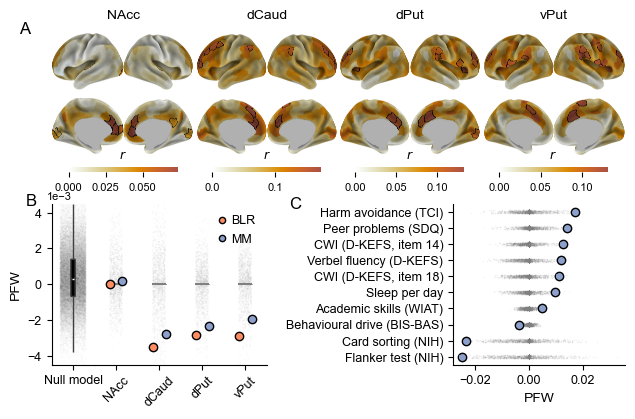

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
# gridspec inside gridspec
fig = plt.figure(figsize=(7.4, 4.5))

# create gridspec between brains and scatter plot
gs0 = gridspec.GridSpec(4, 1, height_ratios=(0.01, 0.4, 0.09, 0.5),
                        figure=fig, hspace=0.1, wspace=0)

# Create gridspec for titles
gs_titles = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[0],
                                        hspace=0, wspace=0)
for i, title in enumerate(['NAcc', 'dCaud', 'dPut', 'vPut']):
    ax = fig.add_subplot(gs_titles[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, 0, title, ha="center", va="bottom", fontsize=10)
    sns.despine(left=True, bottom=True, ax=ax)

# create nested gridspec for brains
gs00 = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs0[1],
                                        hspace=0, wspace=0)

count = 0
for view in ['lateral', 'medial']:
    for roi in ['NAc-shell-rh', 'CAU-DA-rh', 'PUT-VA-rh', 'PUT-DP-rh']:
        for hemi in ['left', 'right']:

            # get image
            img = plt.imread(f"../results/figures/HCP/{roi}_{hemi}_{view}.jpeg")
            x_start_buffer = np.nan
            x_finish_buffer = np.nan

            if count == 7 or count == 15:
                x_start_buffer = 5
                x_finish_buffer = 0

            elif count % 2 != 0:
                x_finish_buffer = 50
                x_start_buffer = 5

            if count == 0 or count == 8:
                x_start_buffer = 0
                x_finish_buffer = 5

            elif count % 2 == 0:
                x_start_buffer = 50
                x_finish_buffer = 5

            img_cropped = get_cropped_img(img,
                                          x_start_buffer=x_start_buffer,
                                          x_finish_buffer=x_finish_buffer,
                                          y_start_buffer=1,
                                          y_finish_buffer=1)
            
            # get ax
            ax = fig.add_subplot(gs00[count])
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped, aspect='equal')
            sns.despine(left=True, bottom=True, ax=ax)
            if count == 0:
                ax.text(-0.45, 1.0, "A", fontsize=12, ha='left', transform=ax.transAxes)
            count = count+1

# Create gridspec for colorbars

x = (3, 19, 6, 19, 6, 19, 6, 19, 3)
gs_bars = gridspec.GridSpecFromSubplotSpec(5, 9,
                                           width_ratios=x,
                                           subplot_spec=gs0[2],
                                           hspace=0, wspace=0)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# minColor = 0.00
# maxColor = 0.85
cmap = truncate_colormap(cmr.prinsenvlag_r, 0.5, 1.0)
count = 0
for i in range(9):
    ax = fig.add_subplot(gs_bars[i])
    if i in [1, 3, 5, 7]:
        maxbin = np.max(abs(plot_data_arrays[:, count]))
        minbin = 0 #maxbin*-1
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
        cb1.ax.tick_params(labelsize=8)
        cb1.ax.locator_params(nbins=3)
        cb1.outline.set_visible(False)
        ax.set_title('$\it{r}$', fontsize=9)
        sns.despine(ax=ax, left=True, bottom=True)
        count = count+1
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)

# Create gridspec for bottom graphs         
gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=(.5, .1, .4), wspace=0.5,
                                        subplot_spec=gs0[3])

# Create a gridspec inside the gridspec yo
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=(.2, .8),
                                        subplot_spec=gs01[0], hspace=0, wspace=0)

ax = fig.add_subplot(gs02[0])
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# Null model boxplots
pal = [
       sns.color_palette("Set2")[0], 
       sns.color_palette("Set2")[6],
       ]
pal = ['grey', 'grey']
ylims = (-0.0045, 0.0045)

df = df_all.copy()
df['desc'] = df['roi'].copy()
df.loc[df.model =='permutation', "desc"] = "permutation"
df.loc[df.model =='SC-Cort', "desc"] = "SC-Cort"
df.loc[df.model =='Cort-Cort', "desc"] = "Cort-Cort"

# Plot the null models first.
data = df.loc[(df.model != 'model') & (df.desc == "SC-Cort")]
quantile_data = data.copy()
sns.boxplot(data=data,
            ax=ax,
            x="desc",
            y='value',
            zorder=1,
            legend=False,
            notch=True,
            showcaps=False,
            showfliers=False,
            boxprops={"facecolor": 'k'},
            medianprops={"color": "w", "linewidth": 1},
            width=0.10,
            )

sns.stripplot(data=data,
              ax=ax,
              y='value',
              x='desc',
              palette=pal,
              dodge=False,
              zorder=0,
              size=1,
              alpha=0.025,
              jitter=0.3,
              legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.yaxis.offsetText.set_fontsize(8)
ax.set_ylabel("PFW", fontsize=10)
ax.set_xlabel("")
sns.despine(ax=ax)
ax.set_ylim(ylims)
ax.set_xticklabels(["Null model"])
ax.text(-0.6, 0.99, "B", fontsize=12, ha='left',transform=ax.transAxes)
t = ax.yaxis.get_offset_text()
t.set_x(-0.1)

# plot actual model
ax = fig.add_subplot(gs02[1])
pal = [sns.color_palette("Set2")[1], sns.color_palette("Set2")[2]]
df = df_all.copy()
data = df.loc[df.model == 'model']
data['model_label'].replace('logreg','BLR', inplace=True)
data['model_label'].replace('multilayer_metamatch','MM', inplace=True)
data['roi'].replace('NAc-shell','NAcc', inplace=True)
data['roi'].replace('PUT-VA','vPut', inplace=True)
data['roi'].replace('CAU-DA','dCaud', inplace=True)
data['roi'].replace('PUT-DP','dPut', inplace=True)
data = data.groupby(['roi', 'model_label']).mean()

sns.pointplot(data=data,
            ax=ax,
            x="roi",
            y='value',
            order=['NAcc', 'dCaud', 'dPut', 'vPut'],
            hue="model_label",
            hue_order=["BLR", "MM"],
            palette=pal,
            linestyle="none",
            dodge=0.3,
            markersize=6,
            zorder=2,
            mec='k',
            mew=1,
            legend=True)


# Legend
ax.legend(frameon=False, loc='upper right', ncol=1,
          fontsize=9, handlelength=1, markerscale=0.75,
          handletextpad=0.2)

# permutations
df = df_all.copy()
data = df.loc[df.model == 'permutation']
data['model_label'].replace('logreg','LR', inplace=True)
data['model_label'].replace('multilayer_metamatch','MM', inplace=True)
data['roi'].replace('NAc-shell','NAcc', inplace=True)
data['roi'].replace('PUT-VA','vPut', inplace=True)
data['roi'].replace('CAU-DA','dCaud', inplace=True)
data['roi'].replace('PUT-DP','dPut', inplace=True)
sns.stripplot(data=data,
              ax=ax,
              x="roi",
              y='value',
              order=['NAcc', 'dCaud', 'dPut', 'vPut'],
              hue="model_label",
              hue_order=["LR", "MM"],
              palette=['grey', 'grey'],
              zorder=0,
              size=1,
              alpha=0.05,
              jitter=0.15,
              legend=False)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("")
ax.set_yticks([])
ax.set_ylim(ylims)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("")
sns.despine(ax=ax, left=True)

# UKBB plot
ax = fig.add_subplot(gs01[1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left=True, bottom=True, ax=ax)
ax = fig.add_subplot(gs01[2])
n_components = 10
in_file = (f"../results/feature_analysis/UKBB_phenotype-{phenotype}_"
        f"model-multilayer_metamatch{model_suffix}_denoise-{denoise}_"
        f"n_batch-{n_batch}_n_batch_null-{n_batch_null}.csv")

df = pd.read_csv(in_file)

# Create human readable df
df.replace(to_replace='0_HBN_NIH7_Flanker',value="Flanker test (NIH)", inplace=True)
df.replace(to_replace='0_HBN_NIH7_Card',value="Card sorting (NIH)", inplace=True)
df.replace(to_replace='0_GSP_TCI_HarmAvoidance',value="Harm avoidance (TCI)", inplace=True)
df.replace(to_replace='0_eNKI_DKEFSCWI_14',value="CWI (D-KEFS, item 14)", inplace=True)
df.replace(to_replace='0_HBN_SDQ_Peer_Problems',value="Peer problems (SDQ)", inplace=True)
df.replace(to_replace='0_eNKI_VF_41',value="Verbel fluency (D-KEFS)", inplace=True)
df.replace(to_replace='0_eNKI_DKEFSCWI_18',value="CWI (D-KEFS, item 18)", inplace=True)
df.replace(to_replace='0_GSP_BISBAS_BAS_Drive',value="Behavioural drive (BIS-BAS)", inplace=True)
df.replace(to_replace='1_UKBB_Sleep',value="Sleep per day", inplace=True)
df.replace(to_replace='0_eNKI_WIAT_06',value="Academic skills (WIAT)", inplace=True)


# isolate just the stats
stats = df.loc[(df.iteration==0) & (df.fold==0) & (df.permutation == False)]
stats.head()

components_to_keep = stats.component.unique()[np.argsort(stats.p.values)][0:n_components]
print(components_to_keep)
plot_df = df.loc[(df.phenotype == phenotype)
                         & (df.permutation== True)]
mask = plot_df.component.isin(components_to_keep)
plot_df = plot_df.loc[mask]

# second plot df
plot_df_mean = df.loc[(df.phenotype == phenotype)
                         & (df.permutation== False)]

mask = plot_df_mean.component.isin(components_to_keep)
plot_df_mean = plot_df_mean.loc[mask]

# Group by 'component' and calculate the mean value for each component
component_means = plot_df_mean.groupby('component')['value'].mean()

# Sort the components based on mean values in descending order
sorted_components = component_means.sort_values(ascending=False)

# Convert the sorted components to a list
component_list_by_magnitude = sorted_components.index.tolist()

# Strip
sns.stripplot(data=plot_df,
              y='component',
              x='value',
              order=component_list_by_magnitude,
              color='grey',
              alpha=0.1,
              jitter=True,
              zorder=0,
              size=1,
              ax=ax)

sns.pointplot(data=plot_df_mean,
              y='component',
              x='value',
              zorder=1,
              order=component_list_by_magnitude,
              color=sns.color_palette("Set2")[2],
              linestyle='none',
              markersize=6,
              mec='k',
              mew=1,
              ax=ax)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_ylabel("")
ax.text(-0.95, 0.97, "C", fontsize=12, ha='left', transform=ax.transAxes)
ax.set_xlabel("PFW", fontsize=10)
sns.despine(ax=ax)
plt.savefig('../results/figures/SC_pathways.svg')
plt.savefig('../results/figures/SC_pathways.jpeg', dpi=600, transparent=True)
plt.show()


In [7]:

'''
df.replace(to_replace="1_UKBB_BP_eye_C5",value="BP and eye (PC5)", inplace=True)
df.replace(to_replace="1_UKBB_Neuro",value="Neuroticism (EPIN-R)", inplace=True)
df.replace(to_replace="1_UKBB_BP_eye_C4",value="BP and eye (PC4)", inplace=True)

df.replace(to_replace="0_ABCD_cbcl_scr_syn_somatic_r",value="Somatic Complaints (CBCL)", inplace=True)

df.replace(to_replace="0_HBN_SRS_COG_T", value="Social cognition (SRS)", inplace=True)
df.replace(to_replace="0_HBN_SRS_AWR_T", value="Social awareness (SRS)", inplace=True)
df.replace(to_replace="0_HBN_SRS_RRB_T", value="RRB (SRS)", inplace=True)
df.replace(to_replace="0_HBN_NIH7_Pattern", value="Pattern Comparison (NIH)", inplace=True)
df.replace(to_replace="0_eNKI_DKEFSTMT_20",value="TMT (D-KEFS, item 20)", inplace=True)
df.replace(to_replace="0_eNKI_DKEFSTMT_18",value="TMT (D-KEFS, item 18)", inplace=True)
df.replace(to_replace="Body C3",value="Anthropometry (PC3)", inplace=True)
df.replace(to_replace="Time TV ",value="Time spent watching TV", inplace=True)
df.replace(to_replace="Sleep",value="Sleep duration", inplace=True)
df.replace(to_replace="BP eye C5",value="BP and eye (PC5)", inplace=True)
df.replace(to_replace="ECG C2",value="Electrocardiogram (PC2)", inplace=True)
df.replace(to_replace="Dur C2",value="Process duration (PC2)", inplace=True)
df.replace(to_replace="BP eye C6",value="BP and eye (PC6)", inplace=True)
df.replace(to_replace="Trail-o C3",value="Trail making task (PC3)", inplace=True)
df.replace(to_replace="Travel",value="Freq. work travel", inplace=True)
df.replace(to_replace="Age edu ",value="Age finished edu.", inplace=True)
'''

'\ndf.replace(to_replace="1_UKBB_BP_eye_C5",value="BP and eye (PC5)", inplace=True)\ndf.replace(to_replace="1_UKBB_Neuro",value="Neuroticism (EPIN-R)", inplace=True)\ndf.replace(to_replace="1_UKBB_BP_eye_C4",value="BP and eye (PC4)", inplace=True)\n\ndf.replace(to_replace="0_ABCD_cbcl_scr_syn_somatic_r",value="Somatic Complaints (CBCL)", inplace=True)\n\ndf.replace(to_replace="0_HBN_SRS_COG_T", value="Social cognition (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_SRS_AWR_T", value="Social awareness (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_SRS_RRB_T", value="RRB (SRS)", inplace=True)\ndf.replace(to_replace="0_HBN_NIH7_Pattern", value="Pattern Comparison (NIH)", inplace=True)\ndf.replace(to_replace="0_eNKI_DKEFSTMT_20",value="TMT (D-KEFS, item 20)", inplace=True)\ndf.replace(to_replace="0_eNKI_DKEFSTMT_18",value="TMT (D-KEFS, item 18)", inplace=True)\ndf.replace(to_replace="Body C3",value="Anthropometry (PC3)", inplace=True)\ndf.replace(to_replace="Time TV ",value="Time 

## Region-level analyses

### Model comparison and gene comparison scatter plots

In [8]:
import pickle
n_rot = 10000
model = "multilayer_metamatch"
infile = f"../results/whole_brain_features/phenotype-{phenotype}_denoise-{denoise}_model-{model}{model_suffix}_Nrot-{n_rot}_"
df = pd.read_csv(infile+'weighted_degree_model_comparisons.csv')
df.head()

n_rot = 10000
model = "multilayer_metamatch"
infile = f"../results/whole_brain_features/phenotype-{phenotype}_denoise-{denoise}_model-{model}{model_suffix}_Nrot-{n_rot}_"
net_df = pd.read_csv(infile+'network_results.csv')
net_df.head()

with open(infile+"weighted_degree.pickle", 'rb') as handle:
    weighted_degree = pickle.load(handle)

with open(infile+'gene_expression.pickle', 'rb') as handle:
   gene_expression = pickle.load(handle)


## Stats

In [9]:
display(df)

,Unnamed: 0,model,comparison_model,r,p,p_spin,type
0,0,multilayer_metamatch,logreg,0.921993,4.345605e-166,0.0,surface
1,1,multilayer_metamatch,logreg,0.815789,2.065885e-05,0.0,subcortex


In [10]:
import numpy as np
from scipy.stats import t

def CBIG_corrected_resampled_ttest(accuracy_vec, portion, threshold):
    """
    This function tests whether an accuracy vector (obtained from cross-validation) 
    is statistically different from a threshold. The accuracy vector can also
    represent the difference between two classifiers. The key point of this
    function is that it tries to correct for the dependencies between the
    folds, because the sample variance across folds underestimates the true
    variance.

    Parameters:
    accuracy_vec : numpy array of shape (K,), K is the number of folds.
    portion      : float, # test subjects/# training subjects for each cross-validation folds. E.g. portion for 5-fold CV equals 1/4 = 0.25
    threshold    : float, Null hypothesis: mean(accuracy_vec) 

    Returns:
    p            : float, 2-sided p value
    """

    K = len(accuracy_vec)
    assert K > 1, 'Number of folds must be greater than 1'

    # corrected variance
    corrected_variance = (1/K + portion) * np.var(accuracy_vec)

    # tstat
    mu = np.mean(accuracy_vec)
    tval = (mu-threshold) / np.sqrt(corrected_variance)

    # 2-tail p value (degree of freedom is K - 1)
    p = 2 * t.cdf(-abs(tval), K-1)

    return mu, tval, p

In [11]:
from pingouin import ttest
from statsmodels.stats.multitest import multipletests
# comparison to null
results = pd.DataFrame()
for net in net_df.network.unique():
    for model in ['logreg', 'multilayer_metamatch']:
        value = net_df.loc[(net_df.network == net)
                           & (net_df.model == model)
                           & (net_df.permutation == False),
                           "value"].median()

        null_distribution = net_df.loc[(net_df.network == net)
                                       & (net_df.model == model)
                                       & (net_df.permutation == True),
                                       "value"].values
        percentile = (null_distribution < value).mean()
        p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
        

        _results = pd.DataFrame()
        _results['net'] = [net]
        _results['model'] = model
        _results['value'] = value * r_factor
        _results['perc'] = percentile
        _results['p_val'] = p_val
        results = pd.concat([results, _results])
# Correct for mc within model?
# results['p_vals_fdr'] = np.nan
# p_vals = results.loc[results.model == 'metamatch', "p_val"].values
# p_vals_fdr = multipletests(p_vals, method='fdr_bh', alpha=0.05)
# results.loc[results.model == 'metamatch', "p_vals_fdr"] = p_vals_fdr[1]
        
# Compare between models.
for net in net_df.network.unique():
    a = net_df.loc[(net_df.network == net)
                           & (net_df.model == 'logreg')
                           & (net_df.permutation == False),
                           "value"].values
    b = net_df.loc[(net_df.network == net)
                           & (net_df.model == 'multilayer_metamatch')
                           & (net_df.permutation == False),
                           "value"].values

    mu, tval, p = CBIG_corrected_resampled_ttest(a-b, 1/4, 0)
    _results = pd.DataFrame()
    _results['net'] = [net]
    _results['model'] = "comparison"
    _results['t'] = tval
    _results['p_val'] = p
    results = pd.concat([results, _results])
results = results.sort_values(['net', 'model'])

results["fdr_p_val"] = results["p_val"].copy()
for model in ["logreg", "multilayer_metamatch"]:
    pvals = results.loc[results.model == model, "p_val"].values
    fdr_pvals = multipletests(pvals, method='fdr_bh')[1]
    results.loc[results.model == model, "fdr_p_val"] = fdr_pvals
#results = results[["net", "model", "value", "perc", "fdr_p_val", "t"]]
results.round(3).to_csv('../results/networks.csv',index=False)
results.round(4).head(40)

,net,model,value,perc,p_val,t,fdr_p_val
0,Cont,comparison,NaN,NaN,0.6638,0.4348,0.6638
0,Cont,logreg,-0.5472,0.0382,0.0382,NaN,0.0382
0,Cont,multilayer_metamatch,-0.7443,0.0346,0.0346,NaN,0.0461
0,Default,comparison,NaN,NaN,0.4965,0.6802,0.4965
0,Default,logreg,-1.7458,0.0148,0.0148,NaN,0.0299
0,Default,multilayer_metamatch,-1.9580,0.0084,0.0084,NaN,0.0336
0,DorsAttn,comparison,NaN,NaN,0.8931,0.1344,0.8931
0,DorsAttn,logreg,0.3706,0.9738,0.0262,NaN,0.0299
0,DorsAttn,multilayer_metamatch,0.3567,0.9340,0.0660,NaN,0.0660
0,Limbic,comparison,NaN,NaN,0.0786,1.7607,0.0786


In [24]:
# just plot one table
from pingouin import ttest
from statsmodels.stats.multitest import multipletests

r_factor = 1000
model = 'multilayer_metamatch'
results = pd.DataFrame()
for net in net_df.network.unique():

    data = net_df.loc[(net_df.network == net)
                        & (net_df.model == model)
                        & (net_df.permutation == False),
                        "value"]
    median = data.median()
    quantile_low = data.quantile(0.25)
    quantile_high = data.quantile(0.75)
    null_distribution = net_df.loc[(net_df.network == net)
                                    & (net_df.model == model)
                                    & (net_df.permutation == True),
                                    "value"].values
    percentile = (null_distribution < data.median()).mean()
    p_val = (0.5 - (abs(percentile - 0.5))) # Express similar to a p value regardless of direction
    

    _results = pd.DataFrame()
    _results['net'] = [net]
    _results['model'] = model
    _results['value'] = f"{np.round(median*r_factor, 2)} ({np.round(quantile_low*r_factor,2)} - {np.round(quantile_high*r_factor,2)})"
    _results['perc'] = percentile
    _results['p_val'] = p_val
    results = pd.concat([results, _results])

results = results.sort_values(['net', 'model'])
results["fdr_p_val"] = results["p_val"].copy()
pvals = results.loc[results.model == model, "p_val"].values
fdr_pvals = multipletests(pvals, method='fdr_bh')[1]
results.loc[results.model == model, "fdr_p_val"] = fdr_pvals
#results = results[["net", "model", "value", "perc", "fdr_p_val", "t"]]
results.round(3).to_csv('../results/networks_mm.csv',index=False)
results.round(4).head(40)

,net,model,value,perc,p_val,fdr_p_val
0,Cont,multilayer_metamatch,-0.74 (-1.07 - -0.39),0.0346,0.0346,0.0461
0,Default,multilayer_metamatch,-1.96 (-2.32 - -1.67),0.0084,0.0084,0.0336
0,DorsAttn,multilayer_metamatch,0.36 (-0.04 - 0.77),0.9340,0.0660,0.0660
0,Limbic,multilayer_metamatch,-1.26 (-1.46 - -1.04),0.0044,0.0044,0.0336
0,SalVentAttn,multilayer_metamatch,-1.15 (-1.5 - -0.79),0.0248,0.0248,0.0397
0,SomMot,multilayer_metamatch,-1.67 (-2.09 - -1.22),0.0140,0.0140,0.0340
0,Subcortical,multilayer_metamatch,0.22 (-0.08 - 0.47),0.9402,0.0598,0.0660
0,Vis,multilayer_metamatch,1.33 (0.9 - 1.8),0.9830,0.0170,0.0340


### Brain plot

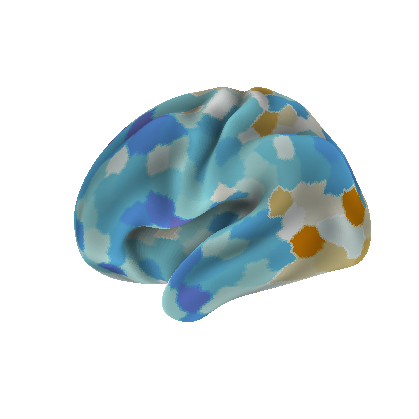

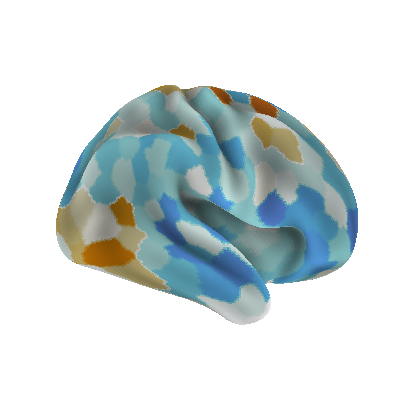

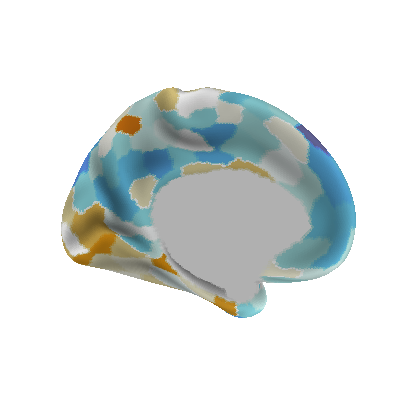

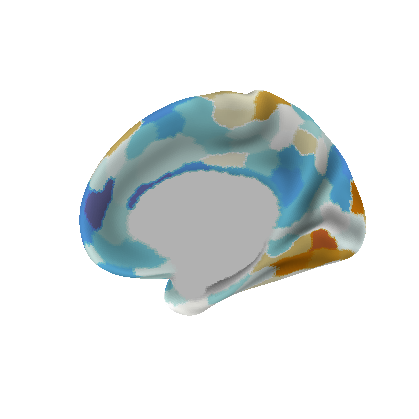

KeyboardInterrupt: 

In [12]:
plot_data_arrays = np.zeros((n_rois, 2))
count = 0
for model in ['logreg', 'multilayer_metamatch']:
    # plot the unthresholded data
    plot_data = np.zeros((454))
    plot_data[54::] = weighted_degree[model][0:400].copy()
    plot_data_arrays[:, count] = plot_data.copy()
    count = count + 1
    #plt.hist(plot_data)
    plt.show()
    # (dont) plot thresholded data
    plot_data_threshold = np.zeros((454))

    pub_surf_plot(plot_data, plot_data_threshold, parc_file,
                  save="../results/figures/features/"+model)
    #create_hist_cbar(plot_data, save="../results/figures/features/"+model)

# plot the comparison too
    

# Plot weights together

0.9219929499559372 0.0


/tmp/ipykernel_3927764/2816779532.py:188: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:grey'` for the same effect.

  sns.stripplot(data=data, ax=ax,


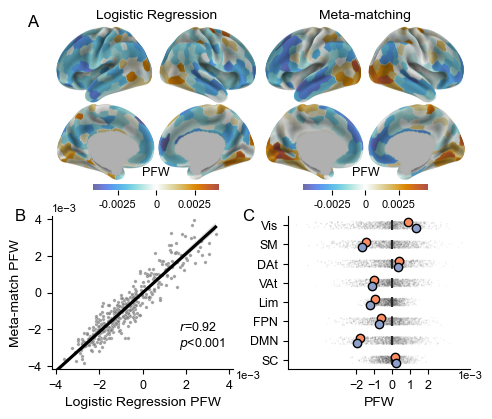

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tkr

# params
location = 'Cortex'  # Subcortex or Cortex
lims=(-0.0042, 0.0042)

# gridspec inside gridspec
fig = plt.figure(figsize=(5.4, 4.6))

# create nested gridspec for top panel
gs = gridspec.GridSpec(4, 1, height_ratios=(0.02, 0.45, 0.08, 0.45), figure=fig,
                       hspace=0.05, wspace=0)

ax = fig.add_subplot(gs[0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.text(0.25, 0, "Logistic Regression", ha="center", va="bottom", fontsize=10)
ax.text(0.75, 0, "Meta-matching", ha="center", va="bottom", fontsize=10)
sns.despine(left=True, bottom=True, ax=ax)


# gridspec for brains
gs_brains = gridspec.GridSpecFromSubplotSpec(2, 4, subplot_spec=gs[1],
                                             hspace=0, wspace=0)

# draw each brain view:
count = 0
for view in ['lateral', 'medial']:
    for model in ['logreg', 'metamatch']:
        for hemi in ['left', 'right']:
            # get ax
            ax = fig.add_subplot(gs_brains[count])
            # get image
            img = plt.imread(f"../results/figures/features/{model}_{hemi}_{view}.jpeg")
            
            if count % 2 != 0 and count < 13:
                x_finish_buffer = 50
            else:
                x_finish_buffer = 5

            if count % 2 == 0 and count > 2:
                x_start_buffer = 50
            else:
                x_start_buffer = 5

            img_cropped = get_cropped_img(img,
                                          x_start_buffer=x_start_buffer,
                                          x_finish_buffer=x_finish_buffer,
                                          y_start_buffer=10,
                                          y_finish_buffer=0)

            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped)
            if count == 0:
                ax.text(-0.3, 1.0, "A", fontsize=12, ha='left', transform=ax.transAxes)
            count = count+1
            sns.despine(left=True, bottom=True, ax=ax)


# Create gridspec for colorbars
gs_bars_inner = gridspec.GridSpecFromSubplotSpec(5, 5, width_ratios=(0.1, 0.3, 0.2, 0.3, 0.1), subplot_spec=gs[2],
                            hspace=0, wspace=0)
cmap=cmr.prinsenvlag_r
count = 0

for i in range(5):
    if i == 1 or i == 3:
        ax = fig.add_subplot(gs_bars_inner[i])
        maxbin = np.max(abs(plot_data_arrays[:, count]))
        minbin = maxbin*-1
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal',
                                        format=tkr.FormatStrFormatter('%.2g'))
        cb1.ax.tick_params(labelsize=8)
        cb1.outline.set_visible(False)
        ax.set_title('PFW', fontsize=9)
        sns.despine(ax=ax, left=True, bottom=True)
        count = count + 1
    else:
        ax = fig.add_subplot(gs_bars_inner[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(left=True, bottom=True, ax=ax)

# scatter plot ax!
gs_plots = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[3],
                                             hspace=0, wspace=0.3)
ax = fig.add_subplot(gs_plots[0])
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# create a df for plotting
plot_df = pd.DataFrame()
plot_df['MM weights'] = weighted_degree["multilayer_metamatch"]
plot_df['LR weights'] = weighted_degree["logreg"]
plot_df['location'] = ["Cortex"] * 400 + ["Subcortex"] * 19
plot_df = plot_df.loc[plot_df['location'] == location]
sns.scatterplot(data=plot_df,
                x="LR weights",
                y="MM weights",
                color='grey',
                s=6,
                alpha=0.75,
                ax=ax,
                zorder=0,
                legend=False)
    
sns.regplot(data=plot_df,
            x="LR weights",
            y="MM weights",
            color='k',
            scatter=False,
            ax=ax)

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=9)

ax.yaxis.offsetText.set_fontsize(8)
ax.xaxis.offsetText.set_fontsize(8)
ax.get_xaxis().get_offset_text().set_position((1.15, 0))
ax.xaxis.OFFSETTEXTPAD = -15

ax.set_ylabel("Meta-match PFW", fontsize=10)
ax.set_ylim(lims)
ax.set_xlim(lims)
ax.set_xlabel("Logistic Regression PFW", fontsize=10)
ax.set_xticks([-0.004, -0.002, 0, 0.002, 0.004])
ax.set_yticks([-0.004, -0.002, 0, 0.002, 0.004])
ax.text(-0.2, 0.97, "B", fontsize=12, ha='left',transform=ax.transAxes)

# r and p val:
if location == "Cortex":
    loc = "surface"
else:
    loc = "subcortex"
r_val = df.loc[df.type == loc, "r"].values[0]
p_val = df.loc[df.type == loc, "p_spin"].values[0]
print(r_val, p_val)
if p_val < 0.001:
    text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
            +'$\it{p}$'+'<0.001')
else:
    text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
            +'$\it{p}$'+'='+ str(p_val))
ax.text(0.70, 0.15, text, fontsize=9, ha='left', transform=ax.transAxes)
sns.despine(ax=ax)

# Network plot
ax = fig.add_subplot(gs_plots[1])
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
# gridspec inside gridspec
# make networks short and readable
repl_dict = {"SomMot": "SM",
             "DorsAttn": "DAt",
             "SalVentAttn": "VAt",
             "Limbic": "Lim",
             "Cont": "FPN",
             "Default": "DMN",
             "Subcortical": "SC"}
net_df.replace(repl_dict, inplace=True)
net_order = ["Vis", "SM", "DAt", "VAt", "Lim", "FPN", "DMN", "SC"]
data = net_df[net_df.permutation == False].groupby(['network', 'model']).mean().reset_index()

sns.pointplot(data=data, ax=ax,
            x="value",
            y='network',
            order=net_order,
            hue="model",
            hue_order=["logreg", "multilayer_metamatch"],
            palette=pal,
            linestyle="none",
            dodge=0.3,
            markersize=6,
            zorder=2,
            mec='k',
            mew=1,
            legend=False)

data = net_df[net_df.permutation == True]
sns.stripplot(data=data, ax=ax,
            x="value",
            y='network',
            order=net_order,
            hue="model",
            hue_order=["logreg", "multilayer_metamatch"],
            color='grey',
            alpha=0.10,
            zorder=0, jitter=0.2,
            size=1, legend=False
             )

# plot formatting
ax.tick_params(axis='both', which='major', labelsize=9)
ax.tick_params(axis='both', which='minor', labelsize=9)
ax.yaxis.offsetText.set_fontsize(8)
ax.xaxis.offsetText.set_fontsize(8)
ax.get_xaxis().get_offset_text().set_position((1.07, 0))
ax.xaxis.OFFSETTEXTPAD = -15
ax.set_xlabel("PFW", fontsize=10)
ax.set_ylabel("", fontsize=0)
ax.set_xticks([-0.002, -0.001, 0, 0.001, 0.002])
ax.text(-0.25, 0.97, "C", fontsize=12, ha='left',transform=ax.transAxes)
sns.despine(ax=ax)
plt.savefig('../results/figures/weight_comparison_'+location+'.svg')
plt.savefig('../results/figures/weight_comparison_'+location+'.jpeg', dpi=600, bbox_inches='tight')
plt.show()

# Genes

## Gene stats

In [ ]:
n_rot = 10000
model = "multilayer_metamatch"
infile = f"../results/whole_brain_features/phenotype-{phenotype}_denoise-{denoise}_model-{model}{model_suffix}_Nrot-{n_rot}_"
gene_df = pd.read_csv(infile+'gene_comparisons.csv')

# fdr correct within model (8 comparisons, I guess?)
gene_df["fdr_p_val"] = np.nan
for model in gene_df.a_label.unique():
    pvals = gene_df.loc[gene_df.a_label == model, "p_spin"]
    fdr_pvals = multipletests(pvals, method='fdr_bh')[1]
    gene_df.loc[gene_df.a_label == model, "fdr_p_val"] = fdr_pvals

gene_df = gene_df[['a_label', 'type', 'b_label', 'r', 'fdr_p_val', "p_spin"]]
gene_df['r'] = gene_df['r'].round(2)
gene_df.sort_values(['a_label', 'type', 'b_label'], inplace=True)
gene_df.round(3).to_csv('../results/genes.csv',index=False)
gene_df.head(20)

,a_label,type,b_label,r,fdr_p_val,p_spin
15,logreg,subcortex,ADCK1,0.05,0.418200,0.41820
11,logreg,subcortex,GRID2,0.48,0.043200,0.02235
9,logreg,subcortex,KIT,0.28,0.140057,0.12255
13,logreg,subcortex,WDR7,-0.54,0.022933,0.00860
14,logreg,surface,ADCK1,-0.11,0.043600,0.03270
10,logreg,surface,GRID2,-0.31,0.000200,0.00005
8,logreg,surface,KIT,0.12,0.043200,0.02700
12,logreg,surface,WDR7,-0.29,0.000000,0.00000
7,multilayer_metamatch,subcortex,ADCK1,0.16,0.251450,0.25145
3,multilayer_metamatch,subcortex,GRID2,0.39,0.070000,0.05250


## Gene plots

/tmp/ipykernel_3927764/307617593.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_data[54::] = gene_expression[gene][0:400].copy()


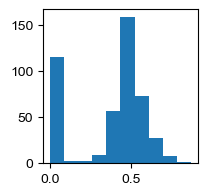

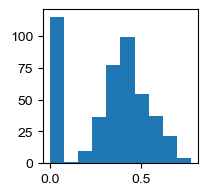

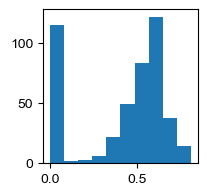

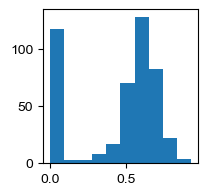

In [ ]:
genes = ['KIT', 'GRID2', 'WDR7', 'ADCK1']
plot_data_arrays = np.zeros((n_rois, len(genes)))
count = 0

for gene in genes:
    # plot the unthresholded data
    plot_data = np.zeros((454))
    plot_data[54::] = gene_expression[gene][0:400].copy()
    plot_data[np.isnan(plot_data)] = 0
    plot_data_arrays[:, count] = plot_data.copy()
    count = count + 1
    plt.figure(figsize=(2,2))
    plt.hist(plot_data)
    plt.show()
    # plot thresholded data
    plot_data_threshold = np.zeros((454))

    # pub_surf_plot(plot_data, plot_data_threshold, parc_file, cmap=cmr.prinsenvlag,
    #               threshold=np.nanmin(gene_expression[gene][0:400].copy()),
    #               save="../results/figures/features/"+gene)
    #create_hist_cbar(plot_data, save="../results/figures/features/"+gene)

0.12 0.05936
-0.31 0.0
-0.3 0.0004
-0.14 0.0247


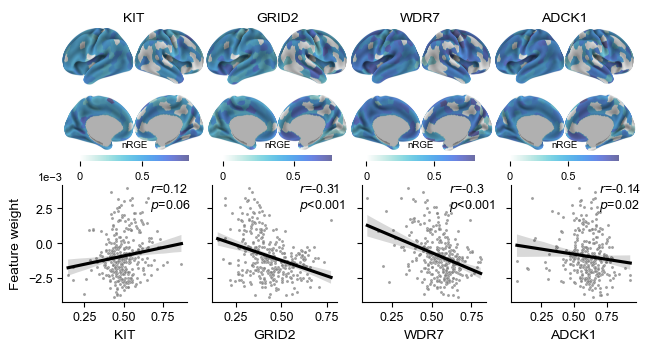

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# params
location = 'Cortex'  # Subcortex or Cortex
lims=(-0.0042, 0.0042)

# gridspec inside gridspec
fig = plt.figure(figsize=(7.4, 3.8))

# create nested gridspec for top panel
gs = gridspec.GridSpec(4, 1, height_ratios=(0.05, 0.45, 0.10, 0.4), figure=fig,
                       hspace=0, wspace=0)

# Create gridspec for titles
gs_titles = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],
                            hspace=0, wspace=0)

for i, title in enumerate(genes):
    ax = fig.add_subplot(gs_titles[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, 0, title, ha="center", va="bottom", fontsize=10)
    sns.despine(left=True, bottom=True, ax=ax)

# create nested gridspec for middle panel
gs_brains = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[1],
                                          hspace=0, wspace=0)

# draw each brain view:
count = 0
for view in ['lateral', 'medial']:
    for gene in genes:
        for hemi in ['left', 'right']:
            # get ax
            ax = fig.add_subplot(gs_brains[count])
            # get image
            img = plt.imread(f"../results/figures/features/{gene}_{hemi}_{view}.jpeg")
            
            if count % 2 != 0 and count < 13:
                x_finish_buffer = 50
            else:
                x_finish_buffer = 5

            if count % 2 == 0 and count > 2:
                x_start_buffer = 50
            else:
                x_start_buffer = 5

            img_cropped = get_cropped_img(img,
                                          x_start_buffer=x_start_buffer,
                                          x_finish_buffer=x_finish_buffer,
                                          y_start_buffer=10,
                                          y_finish_buffer=0)

            # get ax
            #ax = axs[ax_list[count]]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped)
            count = count+1
            sns.despine(left=True, bottom=True, ax=ax)

# Create gridspec for colorbars
            x = (3, 19, 6, 19, 6, 19, 6, 19, 3)
gs_bars = gridspec.GridSpecFromSubplotSpec(5, len(x), width_ratios=x, subplot_spec=gs[2],
                            hspace=0, wspace=0)

cmap = cmr.prinsenvlag
colors = cmap(np.linspace(0.5, 1, cmap.N // 2))

# Create a new colormap from those colors
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

count = 0

for i in range(len(x)):
    ax = fig.add_subplot(gs_bars[i])
    if i in [1, 3, 5, 7]:
        maxbin = np.max(abs(plot_data_arrays[:, count]))
        minbin = 0  # NOTE given the data min = 0
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal',
                                        format=tkr.FormatStrFormatter('%.3g'))
        cb1.ax.tick_params(labelsize=8)
        cb1.outline.set_visible(False)
        ax.set_title('nRGE', fontsize=7)
        sns.despine(ax=ax, left=True, bottom=True)
        count = count+1
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)

# create nested gridspec for scatterplots
gs_scat = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3])

count = 0
for i, gene in enumerate(genes):

    # get ax
    ax = fig.add_subplot(gs_scat[i])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # create df
    plot_df = pd.DataFrame()
    plot_df['MM weights'] = weighted_degree["multilayer_metamatch"]
    plot_df[gene] = gene_expression[gene].values
    plot_df['location'] = ["Cortex"] * 400 + ["Subcortex"] * 19
    plot_df = plot_df.loc[plot_df['location'] == location]

    sns.scatterplot(data=plot_df,
                    x=gene,
                    y="MM weights",
                    color='grey',
                    s=5,
                    alpha=0.75,
                    ax=ax,
                    zorder=0,
                    legend=False)

    sns.regplot(data=plot_df,
                x=gene,
                y="MM weights",
                color='k',
                scatter=False,
                ax=ax)
    
    # plot formatting
    ax.tick_params(axis='both', which='major', labelsize=9)
    if i==0:
        ax.set_ylabel("Feature weight", fontsize=10)
        ax.yaxis.offsetText.set_fontsize(8)
    else:
        ax.set_ylabel("", fontsize=10)
        ax.tick_params(labelleft=False)    


    #ax.set_yticks(np.linspace(0, 1, 3))
    
    ax.set_ylim(lims)
    #ax.set_xlim(lims)
    ax.set_xlabel(gene, fontsize=10)
    #ax.set_xticks(np.linspace(0, 1, 3))
    #ax.set_xticklabels(np.linspace(0, 1, 3))
    #ax.set_title('A', loc='left', fontsize=12)
    ax.get_yaxis().get_offset_text().set_position((-0.2, 1.0))
    #ax.xaxis.OFFSETTEXTPAD = -15
    sns.despine(ax=ax)

    # r and p val:
    if location == "Cortex":
        loc = "surface"
    else:
        loc = "subcortex"
    r_val = gene_df.loc[(gene_df.a_label == "multilayer_metamatch") &
                        (gene_df.type == loc) &
                        (gene_df.b_label == gene), "r"].values[0]
    p_val = gene_df.loc[(gene_df.a_label == "multilayer_metamatch") &
                        (gene_df.type == loc) &
                        (gene_df.b_label == gene), "fdr_p_val"].values[0]
    print(r_val, p_val)
    if p_val < 0.001:
        text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
                +'$\it{p}$'+'<0.001')
    else:
        text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
                +'$\it{p}$'+'='+ str(np.round(p_val, 2)))
    ax.text(0.70, 0.80, text, fontsize=9, ha='left', transform=ax.transAxes)
plt.savefig('../results/figures/gene_comparison_'+location+'.svg')
plt.savefig('../results/figures/gene_comparison_'+location+'.jpeg', dpi=600, bbox_inches='tight')
plt.show()

0.12 0.0432
-0.31 0.0002
-0.29 0.0
-0.11 0.0436


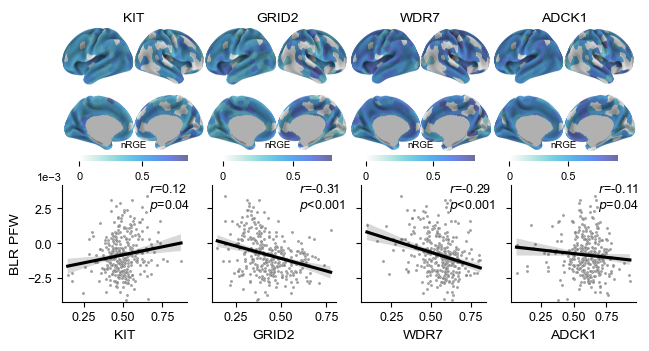

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# params
location = 'Cortex'  # Subcortex or Cortex
lims=(-0.0042, 0.0042)

# gridspec inside gridspec
fig = plt.figure(figsize=(7.4, 3.8))

# create nested gridspec for top panel
gs = gridspec.GridSpec(4, 1, height_ratios=(0.05, 0.45, 0.10, 0.4), figure=fig,
                       hspace=0, wspace=0)

# Create gridspec for titles
gs_titles = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0],
                            hspace=0, wspace=0)

for i, title in enumerate(genes):
    ax = fig.add_subplot(gs_titles[i])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.5, 0, title, ha="center", va="bottom", fontsize=10)
    sns.despine(left=True, bottom=True, ax=ax)

# create nested gridspec for middle panel
gs_brains = gridspec.GridSpecFromSubplotSpec(2, 8, subplot_spec=gs[1],
                                          hspace=0, wspace=0)

# draw each brain view:
count = 0
for view in ['lateral', 'medial']:
    for gene in genes:
        for hemi in ['left', 'right']:
            # get ax
            ax = fig.add_subplot(gs_brains[count])
            # get image
            img = plt.imread(f"../results/figures/features/{gene}_{hemi}_{view}.jpeg")
            
            if count % 2 != 0 and count < 13:
                x_finish_buffer = 50
            else:
                x_finish_buffer = 5

            if count % 2 == 0 and count > 2:
                x_start_buffer = 50
            else:
                x_start_buffer = 5

            img_cropped = get_cropped_img(img,
                                          x_start_buffer=x_start_buffer,
                                          x_finish_buffer=x_finish_buffer,
                                          y_start_buffer=10,
                                          y_finish_buffer=0)

            # get ax
            #ax = axs[ax_list[count]]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img_cropped)
            count = count+1
            sns.despine(left=True, bottom=True, ax=ax)

# Create gridspec for colorbars
            x = (3, 19, 6, 19, 6, 19, 6, 19, 3)
gs_bars = gridspec.GridSpecFromSubplotSpec(5, len(x), width_ratios=x, subplot_spec=gs[2],
                            hspace=0, wspace=0)

cmap = cmr.prinsenvlag
colors = cmap(np.linspace(0.5, 1, cmap.N // 2))

# Create a new colormap from those colors
cmap = LinearSegmentedColormap.from_list('Upper Half', colors)

count = 0

for i in range(len(x)):
    ax = fig.add_subplot(gs_bars[i])
    if i in [1, 3, 5, 7]:
        maxbin = np.max(abs(plot_data_arrays[:, count]))
        minbin = 0  # NOTE given the data min = 0
        norm = mpl.colors.Normalize(vmin=minbin, vmax=maxbin)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal',
                                        format=tkr.FormatStrFormatter('%.3g'))
        cb1.ax.tick_params(labelsize=8)
        cb1.outline.set_visible(False)
        ax.set_title('nRGE', fontsize=7)
        sns.despine(ax=ax, left=True, bottom=True)
        count = count+1
    else:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=True)

# create nested gridspec for scatterplots
gs_scat = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3])

count = 0
for i, gene in enumerate(genes):

    # get ax
    ax = fig.add_subplot(gs_scat[i])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # create df
    plot_df = pd.DataFrame()
    plot_df['LR weights'] = weighted_degree["logreg"]
    plot_df[gene] = gene_expression[gene].values
    plot_df['location'] = ["Cortex"] * 400 + ["Subcortex"] * 19
    plot_df = plot_df.loc[plot_df['location'] == location]

    sns.scatterplot(data=plot_df,
                    x=gene,
                    y="LR weights",
                    color='grey',
                    s=5,
                    alpha=0.75,
                    ax=ax,
                    zorder=0,
                    legend=False)

    sns.regplot(data=plot_df,
                x=gene,
                y="LR weights",
                color='k',
                scatter=False,
                ax=ax)
    
    # plot formatting
    ax.tick_params(axis='both', which='major', labelsize=9)
    if i==0:
        ax.set_ylabel("BLR PFW", fontsize=10)
        ax.yaxis.offsetText.set_fontsize(8)
    else:
        ax.set_ylabel("", fontsize=10)
        ax.tick_params(labelleft=False)    


    #ax.set_yticks(np.linspace(0, 1, 3))
    
    ax.set_ylim(lims)
    #ax.set_xlim(lims)
    ax.set_xlabel(gene, fontsize=10)
    #ax.set_xticks(np.linspace(0, 1, 3))
    #ax.set_xticklabels(np.linspace(0, 1, 3))
    #ax.set_title('A', loc='left', fontsize=12)
    ax.get_yaxis().get_offset_text().set_position((-0.2, 1.0))
    #ax.xaxis.OFFSETTEXTPAD = -15
    sns.despine(ax=ax)

    # r and p val:
    if location == "Cortex":
        loc = "surface"
    else:
        loc = "subcortex"
    r_val = gene_df.loc[(gene_df.a_label == "logreg") &
                        (gene_df.type == loc) &
                        (gene_df.b_label == gene), "r"].values[0]
    p_val = gene_df.loc[(gene_df.a_label == "logreg") &
                        (gene_df.type == loc) &
                        (gene_df.b_label == gene), "fdr_p_val"].values[0]
    print(r_val, p_val)
    if p_val < 0.001:
        text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
                +'$\it{p}$'+'<0.001')
    else:
        text = ('$\it{r}$'+'='+str(np.round(r_val,2))+'\n'
                +'$\it{p}$'+'='+ str(np.round(p_val, 2)))
    ax.text(0.70, 0.80, text, fontsize=9, ha='left', transform=ax.transAxes)
plt.savefig('../results/figures/gene_comparison_'+location+'_logreg.svg')
plt.savefig('../results/figures/gene_comparison_'+location+'_logreg.jpeg', dpi=600, bbox_inches='tight')
plt.show()